# Loading our Finetuned Model

In our previous notebooks we:

- [Built a simple image search engine for fashion products using Jina's Docarray library](https://colab.research.google.com/github/alexcg1/neural-search-notebooks/blob/main/fashion-search/1_build_basic_search/basic_search.ipynb)
- [Finetuned our model using Jina Finetuner](https://colab.research.google.com/github/alexcg1/neural-search-notebooks/blob/main/fashion-search/2_finetune_model/finetune_model.ipynb)

Now we'll integrate our fine-tuned model into our original search engine and compare results

Next time we'll build our fashion search engine into something production-ready using [Jina's neural search framework](https://github.com/jina-ai/jina)

You can download this notebook from [GitHub](https://github.com/alexcg1/neural-search-notebooks). PRs and issues are always welcome!

## Before starting

1. Ensure you've completed the previous two notebooks.
2. Copy the `tuned-model` file from the finetuner tutorial and place it in the same folder as this notebook.

## 📺 Watch the video

Get a guided tour of the notebook and search results with Jack from Jina AI

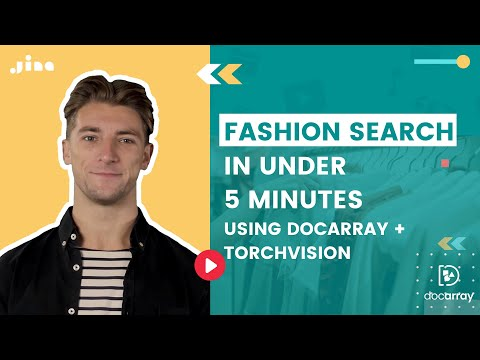

In [54]:
from IPython.display import YouTubeVideo
YouTubeVideo("Amo19S1SrhE", width=800, height=450)

## Configuration

We'll set up some basic variables. Feel free to adapt these for your own project!

In [55]:
# Check if we're running in Google Colab
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

In [56]:
DATA_DIR = "./data"
DATA_PATH = f"{DATA_DIR}/*.jpg"
MAX_DOCS = 1000
QUERY_IMAGE = "./query.jpg" # image we'll use to search with
PLOT_EMBEDDINGS = False # Really useful but have to manually stop it to progress to next cell

# Toy data - If data dir doesn't exist, we'll get data of ~800 fashion images from here
TOY_DATA_URL = "https://github.com/alexcg1/neural-search-notebooks/raw/main/fashion-search/data.zip?raw=true"

## ⚙️ Setup

In [57]:
# We use "[full]" because we want to deal with more complex data like images (as opposed to text)
!pip install "docarray[full]==0.4.4"

In [58]:
from docarray import Document, DocumentArray

## 🖼️ Load images

In [59]:
# Download images if they don't exist
import os

if not os.path.isdir(DATA_DIR) and not os.path.islink(DATA_DIR):
    print(f"Can't find {DATA_DIR}. Downloading toy dataset")
    !wget "$TOY_DATA_URL" -O data.zip
    !unzip -q data.zip # Don't print out every darn filename
    !rm -f data.zip
else:
    print(f"Nothing to download. Using {DATA_DIR} for data")

Nothing to download. Using ./data for data


In [60]:
# Use `.from_files` to quickly load them into a `DocumentArray`
docs = DocumentArray.from_files(DATA_PATH, size=MAX_DOCS)
print(f"{len(docs)} Documents in DocumentArray")

845 Documents in DocumentArray


## 🏭 Apply preprocessing

In [61]:
from docarray import Document

# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [62]:
# apply en masse
docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 845                                   
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       845              False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   845              False            
  uri         ('str',)       845              False

## 🧠 Embed images using original model

In [63]:
!pip install torchvision==0.11.2

In [64]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

In [65]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

In [66]:
docs.embed(model, device=DEVICE)

                             Documents Summary                              
                                                                            
  Length                 845                                                
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    845              False            
  id          ('str',)       845              False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       845              False            
  uri         ('ndarray',)   845              False

## Create query Document

Let's just use the first image from our dataset:

--2022-01-28 12:52:26--  https://github.com/alexcg1/neural-search-notebooks/raw/main/fashion-search/1_build_basic_search/query.jpg
SSL_INIT
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alexcg1/neural-search-notebooks/main/fashion-search/1_build_basic_search/query.jpg [following]
--2022-01-28 12:52:27--  https://raw.githubusercontent.com/alexcg1/neural-search-notebooks/main/fashion-search/1_build_basic_search/query.jpg
SSL_INIT
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2153 (2.1K) [image/jpeg]
Saving to: ‘query.jpg’

query.jpg   

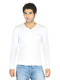

In [67]:
# Download query doc
!wget https://github.com/alexcg1/neural-search-notebooks/raw/main/fashion-search/1_build_basic_search/query.jpg -O query.jpg

query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()

In [68]:
# Throw the one Document into a DocumentArray, since that's what we're matching against
query_docs = DocumentArray([query_doc])

In [69]:
# Apply same preprocessing
query_docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 1                                     
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   1                False            
  uri         ('str',)       1                False

In [70]:
# ...and create embedding just like we did with the dataset
query_docs.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

                             Documents Summary                              
                                                                            
  Length                 1                                                  
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    1                False            
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       1                False            
  uri         ('ndarray',)   1                False

## Get matches

In [71]:
query_docs.match(docs, limit=9)

## See the results

As you can see, the model is finding matches based on the input images - including the human wearing the clothes! In reality we want to match the clothes themselves, so later we'll fine-tune our model using Jina AI's [finetuner](https://finetuner.jina.ai).

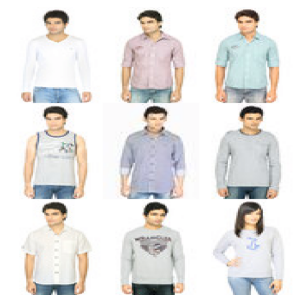

In [72]:
(DocumentArray(query_doc.matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())).plot_image_sprites()

## Load new model

In [73]:
model = torch.load("tuned-model")

## 🧠 Embed images using new model

In [74]:
docs = DocumentArray.from_files(DATA_PATH, size=MAX_DOCS)

In [75]:
# pre-process en masse
docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 845                                   
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       845              False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   845              False            
  uri         ('str',)       845              False

In [76]:
docs.embed(model, device=DEVICE)

                             Documents Summary                              
                                                                            
  Length                 845                                                
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    845              False            
  id          ('str',)       845              False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       845              False            
  uri         ('ndarray',)   845              False

## Embed query Document

Let's just use the first image from our dataset:

In [77]:
query_doc = Document(uri=QUERY_IMAGE)

In [78]:
# Throw the one Document into a DocumentArray, since that's what we're matching against
query_docs = DocumentArray([query_doc])

In [79]:
# Apply same preprocessing
query_docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 1                                     
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   1                False            
  uri         ('str',)       1                False

In [80]:
# ...and create embedding just like we did before
query_docs.embed(model, device=DEVICE)

                             Documents Summary                              
                                                                            
  Length                 1                                                  
  Homogenous Documents   True                                               
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri', 'embedding')  
                                                                            
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  embedding   ('Tensor',)    1                False            
  id          ('str',)       1                False            
  mime_type   ('str',)       1                False            
  tensor      ('str',)       1                False            
  uri         ('ndarray',)   1                False

## Get matches

In [81]:
query_docs.match(docs, limit=9)

## See the results

As you can see, with a fine-tuned model we get much better results

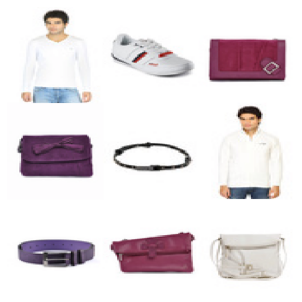

In [82]:
(DocumentArray(query_doc.matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())).plot_image_sprites()